# Installations and Imports

In [1]:
%%capture
!pip install mujoco mujoco_mjx brax playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!apt-get update
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf

In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import mediapy
import os
from tqdm import tqdm

os.environ["MUJOCO_GL"] = "egl"

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [2]:
# import mujoco after setting MUJOCO_GL to prevent errors in video rendering
import mujoco

# Clone Repository

In [3]:
!git clone https://github.com/shaoanlu/control_system_project_template.git

fatal: destination path 'control_system_project_template' already exists and is not an empty directory.


In [4]:
%cd control_system_project_template

/content/control_system_project_template


In [5]:
!pwd

/content/control_system_project_template


# Run simulation

In [6]:
from examples.mujoco_Go1.env_wrapper import Go1Env
from examples.mujoco_Go1.ppo import PPO, PPOParams, PPOParamsBuilder
from src.control.controller_factory import ControllerFactory

In [7]:
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]


def sample_pert(rng, env, state):
    """
    Random purterbation to the robot
    """
    rng, key1, key2 = jax.random.split(rng, 3)
    pert_mag = jax.random.uniform(key1, minval=velocity_kick_range[0], maxval=velocity_kick_range[1])
    duration_seconds = jax.random.uniform(key2, minval=kick_duration_range[0], maxval=kick_duration_range[1])
    duration_steps = jax.numpy.round(duration_seconds / env.dt).astype(jax.numpy.int32)
    state.info["pert_mag"] = pert_mag
    state.info["pert_duration"] = duration_steps
    state.info["pert_duration_seconds"] = duration_seconds
    return rng

## Demo 1: Yaw Command Control With The Factory Pattern
### Instantiate simulator and controller
Choose `env_name` between `Go1Handstand` and `Go1JoystickFlatTerrain`. This parameter determines the type of controller created by the factory.

In [ ]:
# instantiate mujoco Env
env_name = "Go1JoystickFlatTerrain"  # Choose between Go1Handstand and Go1JoystickFlatTerrain
rng = jax.random.PRNGKey(0)
env = Go1Env(env_name=env_name)

# Instantiate controller based on env_name
factory = ControllerFactory()
factory.register_controller(PPOParams, PPO)
controller_config = {"npy_path": f"examples/mujoco_Go1/nn_params/{env_name}"}
ppo_params = PPOParamsBuilder().build(config=controller_config)
controller = factory.build(params=ppo_params)

In [ ]:
rollout = []
modify_scene_fns = []
swing_peak = []
linvel = []
angvel = []
ref_commands = []

# Play around the controller by modifying command during runtime
cmd_yaw = np.pi
command = jax.numpy.array([0, 0, cmd_yaw])

# start closed-loop sim
state = env.reset(rng)
for i in tqdm(range(env.env_cfg.episode_length)):
    # halve target yaw velocity every 250 steps
    if (env_name == "Go1JoystickFlatTerrain") and (i % 250 == 0):
        cmd_yaw /= 2
        command = jax.numpy.array([0, 0, cmd_yaw])
        state.info["command"] = command
    try:
        if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
            rng = sample_pert(rng, env, state)
    except:
        pass
    _, rng = jax.random.split(rng)  # this will randomize perturbation

    ctrl = controller.control(state.obs["state"])  # controller step
    state = env.step(state, ctrl)  # simulator step

    # record
    rollout.append(state)
    ref_commands.append(command)
    linvel.append(env.get_global_linvel(state.data))
    angvel.append(env.get_gyro(state.data))
    if env_name == "Go1JoystickFlatTerrain":
        swing_peak.append(state.info["swing_peak"])

100%|██████████| 1000/1000 [01:00<00:00, 16.59it/s]


### Visualize Simulation Result

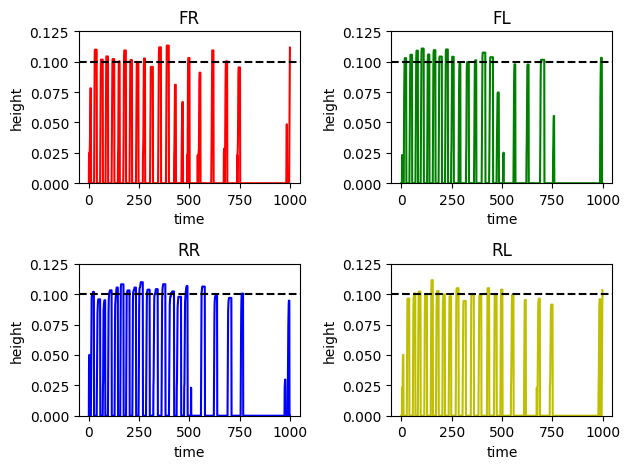

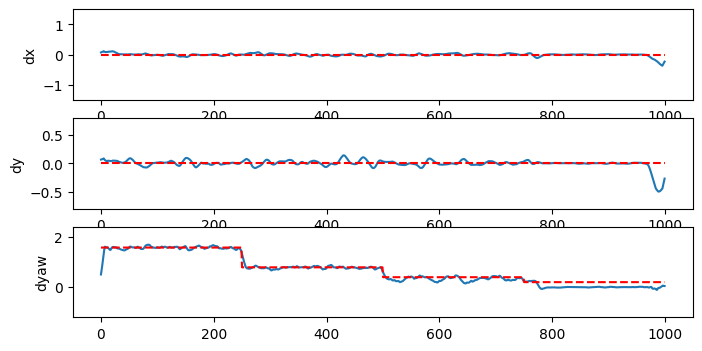

In [ ]:
# visualization
# Plot each foot in a 2x2 grid.
if env_name == "Go1JoystickFlatTerrain":
    swing_peak = jax.numpy.array(swing_peak)
    names = ["FR", "FL", "RR", "RL"]
    colors = ["r", "g", "b", "y"]
    fig, axs = plt.subplots(2, 2)
    for i, ax in enumerate(axs.flat):
        ax.plot(swing_peak[:, i], color=colors[i])
        ax.set_ylim([0, env.env_cfg.reward_config.max_foot_height * 1.25])
        ax.axhline(env.env_cfg.reward_config.max_foot_height, color="k", linestyle="--")
        ax.set_title(names[i])
        ax.set_xlabel("time")
        ax.set_ylabel("height")
    plt.tight_layout()
    plt.show()

    linvel_x = jax.numpy.array(linvel)[:, 0]
    linvel_y = jax.numpy.array(linvel)[:, 1]
    angvel_yaw = jax.numpy.array(angvel)[:, 2]

    # Plot whether velocity is within the command range.
    linvel_x = jax.numpy.convolve(linvel_x, jax.numpy.ones(10) / 10, mode="same")
    linvel_y = jax.numpy.convolve(linvel_y, jax.numpy.ones(10) / 10, mode="same")
    angvel_yaw = jax.numpy.convolve(angvel_yaw, jax.numpy.ones(10) / 10, mode="same")

    fig, axes = plt.subplots(3, 1, figsize=(8, 4))
    axes[0].plot(linvel_x)
    axes[1].plot(linvel_y)
    axes[2].plot(angvel_yaw)

    axes[0].set_ylim(-env.env_cfg.command_config.a[0], env.env_cfg.command_config.a[0])
    axes[1].set_ylim(-env.env_cfg.command_config.a[1], env.env_cfg.command_config.a[1])
    axes[2].set_ylim(-env.env_cfg.command_config.a[2], env.env_cfg.command_config.a[2] * 2)

    ref_cmd = jax.numpy.vstack(ref_commands)
    for i, ax in enumerate(axes):
        ax.plot(ref_cmd[:, i], color="red", linestyle="--")

    labels = ["dx", "dy", "dyaw"]
    for i, ax in enumerate(axes):
        ax.set_ylabel(labels[i])
    fig.suptitle("Command tracking")
else:
    print("No signal plots for Go1Handstand")

### Video rendering

In [ ]:
render_every = 2
fps = 1.0 / env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = env.render(traj, camera="track", scene_option=scene_option, height=480, width=640)
mediapy.show_video(frames, fps=fps, loop=False)

## Demo 2: Acrobatic movement With The Strategy Pattern
This demo demonstrates the usage of strategy pattern to manage switching controller at runtime.

The controller is able to perform 4 tasks, and achieves acrobatic movement uninterrupted.
- Handstand
- Footstand
- Yaw command tracking
- recovery from failures

In [11]:
from typing import Dict

from examples.mujoco_Go1.go1_acrobat_controller import create_go1_acrobat_controller_manager
from examples.mujoco_Go1.go1_acrobat_controller import Go1ControllerType
from examples.mujoco_Go1.recovery_checker import RecoverState

In [12]:
# instantiate mujoco Env
env_name = "Go1Handstand"  # Fixed to Go1Handstand
rng = jax.random.PRNGKey(42)
env = Go1Env(env_name=env_name)

# other envs have their config & params used by the controller adapters
joystick_env = Go1Env(env_name="Go1JoystickFlatTerrain")
handstand_env = Go1Env(env_name="Go1Handstand")
getup_env = Go1Env(env_name="Go1Getup")

There are three polocies available for Go1 env and are defined in `Go1ControllerType` as below
```python
class Go1ControllerType(Enum):
    JOYSTICK = auto()
    HANDSTAND = auto()
    FOOTSTAND = auto()
    GETUP = auto()
```

In [13]:
def print_switch_controller(
    prev_controller_type: Go1ControllerType, current_controller_type: Go1ControllerType, step: int
):
    """Helper function to print active controller type"""
    if current_controller_type != prev_controller_type:
        print(f"\n[Step {i}] Switch from {prev_controller_type} to {current_controller_type}\n")


# Set up controller configurations
# this config format is relatively ad hoc and is coupled with create_go1_acrobat_controller_manager(...)
controller_configs: Dict[Go1ControllerType, Dict[str, str]] = {
    Go1ControllerType.JOYSTICK: {"npy_path": "examples/mujoco_Go1/nn_params/Go1JoystickFlatTerrain"},
    Go1ControllerType.FOOTSTAND: {"npy_path": "examples/mujoco_Go1/nn_params/Go1Footstand"},
    Go1ControllerType.HANDSTAND: {"npy_path": "examples/mujoco_Go1/nn_params/Go1Handstand"},
    Go1ControllerType.GETUP: {"npy_path": "examples/mujoco_Go1/nn_params/Go1Getup"},
}

# Create controller manager, this class provides a switch_controller() method for changing controller at runtime
controller_manager = create_go1_acrobat_controller_manager(
    controller_factory=ControllerFactory(),
    params_builder=PPOParamsBuilder(),
    controller_configs=controller_configs,
    joystick_env=joystick_env,
    handstand_env=handstand_env,
    getup_env=getup_env,
)

### Run closed-loop simulation

In [26]:
rollout = []

# Play around the controller by modifying command during runtime
joystick_command = jax.numpy.array([0, 0, np.pi / 2])
controller_manager.set_command(joystick_command)
prev_controller_type = controller_manager._active_type

# recover stae machine
recover_state = RecoverState(getup_env, handstand_env)

# start closed-loop sim
state = env.reset(rng)
sim_steps = int(env.env_cfg.episode_length * 1.5)
for i in tqdm(range(sim_steps)):
    state.info["command"] = joystick_command
    try:
        if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
            rng = sample_pert(rng, env, state)
    except:
        pass
    _, rng = jax.random.split(rng)  # this will randomize perturbation

    # Switch controllers based on timestep
    if i <= sim_steps // 3:
        controller_manager.switch_controller(Go1ControllerType.HANDSTAND)
    elif i > 2 * sim_steps // 3:
        controller_manager.switch_controller(Go1ControllerType.FOOTSTAND)
    else:
        controller_manager.switch_controller(Go1ControllerType.JOYSTICK)

    # switch to recover controller if robot falls down
    if recover_state.check(state=state, step=i):
        controller_manager.switch_controller(Go1ControllerType.GETUP)

    # print out controller switch if detected
    print_switch_controller(prev_controller_type, controller_manager._active_type, i)
    prev_controller_type = controller_manager._active_type

    # controller & simulator step
    # note that the controll manager take the state as input instead of state.obs["state"]
    ctrl = controller_manager.control(state)
    state = env.step(state, ctrl)

    # record
    rollout.append(state)

  1%|▏         | 10/750 [00:00<00:08, 89.48it/s]


[Step 0] Switch from Go1ControllerType.FOOTSTAND to Go1ControllerType.HANDSTAND



 35%|███▍      | 259/750 [00:06<00:08, 60.18it/s]


[Step 251] Switch from Go1ControllerType.HANDSTAND to Go1ControllerType.JOYSTICK



 42%|████▏     | 313/750 [00:07<00:06, 65.38it/s]


[Step 301] Switch from Go1ControllerType.JOYSTICK to Go1ControllerType.GETUP



 51%|█████     | 381/750 [00:08<00:05, 66.22it/s]


[Step 371] Switch from Go1ControllerType.GETUP to Go1ControllerType.JOYSTICK



 69%|██████▊   | 514/750 [00:10<00:03, 60.78it/s]


[Step 501] Switch from Go1ControllerType.JOYSTICK to Go1ControllerType.FOOTSTAND



100%|██████████| 750/750 [00:13<00:00, 55.64it/s]


### Video rendering

In [ ]:
render_every = 2  # render every 2 steps
fps = 1.0 / env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False  # set True to visualize collision geom of legs and body (assume rgba defined in xml)
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

frames = env.render(traj, camera="track", scene_option=scene_option, height=480, width=640)
mediapy.show_video(frames, fps=fps, loop=False)

In [29]:
mediapy.write_video("tmp.mp4", frames, fps=fps)